# DIFFERENCTIAL EXPRESSION ANALYSIS OF DUCTAL CELLS

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad("./Data/Peng_annotated.h5ad")

In [3]:
rawdata = adata.raw.to_adata()
rawdata

AnnData object with n_obs × n_vars = 49966 × 24005
    obs: 'cell_name', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_prediction', 'cell_type_prediction_probability', 'per_cluster_celltype', 'per_cluster_proportion', 'Condition'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_prediction_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'per_cluster_celltype_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [4]:
rawdata = rawdata[rawdata.obs.per_cluster_celltype.isin(["Ductal cell","Malign Ductal cell"]),:]
rawdata

sc.pp.filter_genes(rawdata,min_cells=3)
sc.pp.filter_genes(rawdata,min_counts=200)

/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


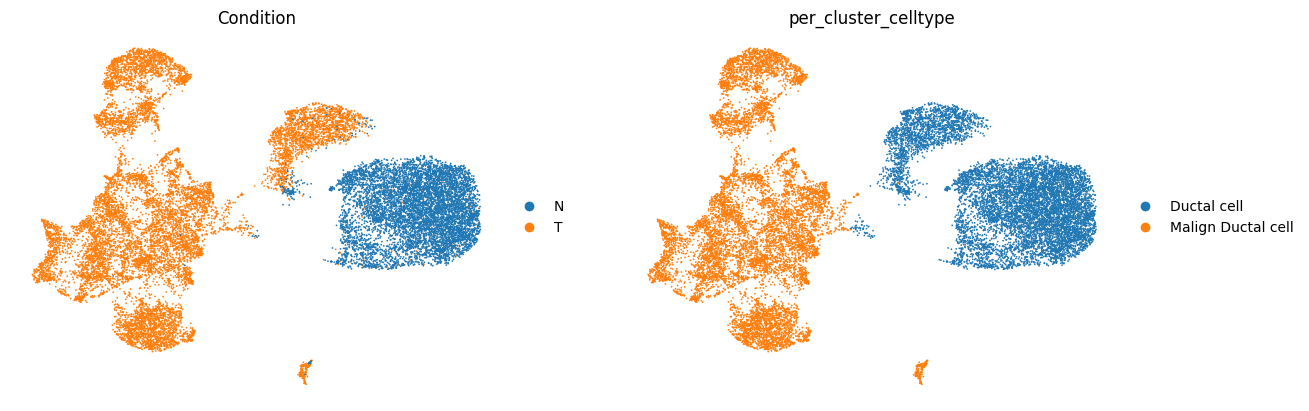

In [5]:
# Compute neighbors using scVI model
sc.pp.neighbors(rawdata, use_rep = 'X_scVI', metric="correlation")
# Generate UMAP and leiden clustering
sc.tl.umap(rawdata, min_dist=0.3)

sc.pl.umap(rawdata, color = ['Condition','per_cluster_celltype'], frameon = False)

In [6]:
sc.tl.rank_genes_groups(rawdata, 'per_cluster_celltype',groups=["Malign Ductal cell"],reference="Ductal cell", method='wilcoxon', key_added = "wilcoxon_malign")

DEG_scanpy = sc.get.rank_genes_groups_df(rawdata, group="Malign Ductal cell",key="wilcoxon_malign")

DEG_scanpy.sort_values('logfoldchanges', ascending=False, inplace=True)

DEG_scanpy_volcano = DEG_scanpy.rename(columns={'pvals_adj': 'padj', 'logfoldchanges': 'log2FoldChange', 'names': 'gene_name'})


In [7]:
#  DEGS
degs_scanpy=set(DEG_scanpy[(DEG_scanpy.pvals_adj<0.05)&(abs(DEG_scanpy.logfoldchanges)>1)].names.tolist())

/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


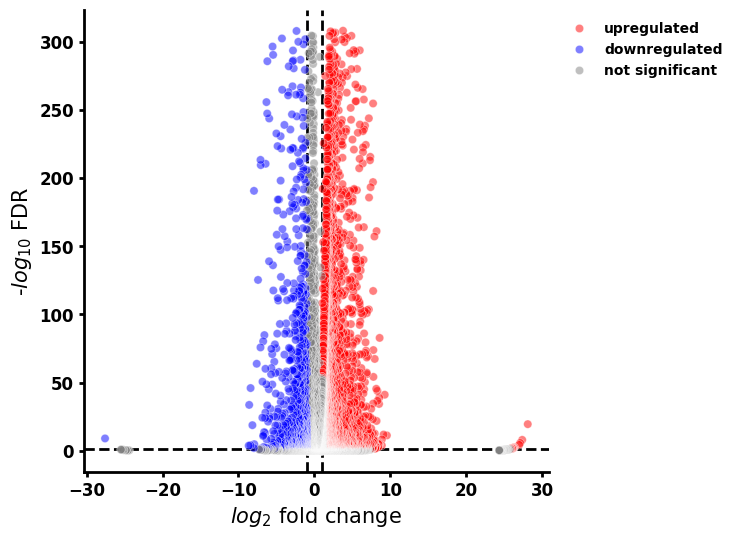

In [8]:
from utils import Volcanoplot

# Create a volcano plot showing the most remarcable genes
Volcanoplot.volcano_plot(DEG_scanpy_volcano,texto=[],path_save="./Results/Diff_exp/Volcano_plot.png" )


Here we can see a few genes with a log fold change > 25, these genes might be otliers so we will eliminate them from the analysis

/home/victor/Documentos/German/sc_rnaseq/Pipeline_Principal/utils/Volcanoplot.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volc['nlog10'] = -np.log10(df_volc.padj)
/home/victor/Documentos/German/sc_rnaseq/Pipeline_Principal/utils/Volcanoplot.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volc.replace([np.inf, -np.inf], np.nan, inplace=True)
/home/victor/Documentos/German/sc_rnaseq/Pipeline_Principal/utils/Volcanoplot.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

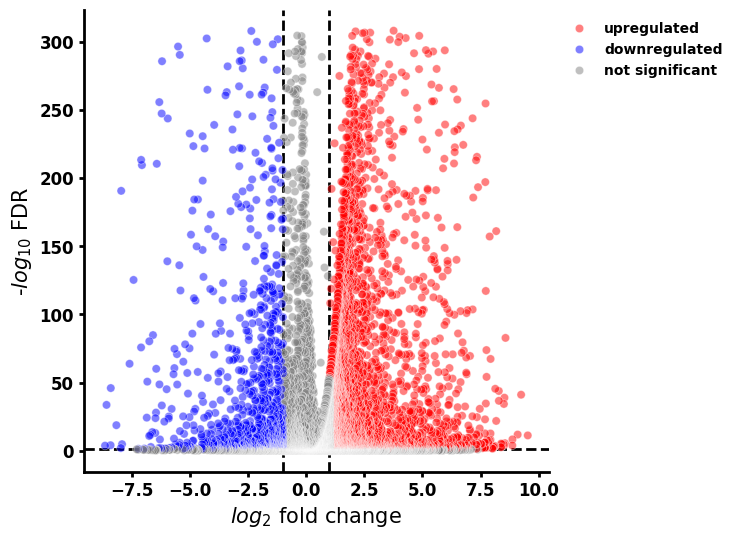

In [9]:
outliers = DEG_scanpy_volcano.gene_name[abs(DEG_scanpy_volcano.log2FoldChange)>20].tolist()
DEG_scanpy_volcano = DEG_scanpy_volcano[np.array([gen not in outliers for gen in DEG_scanpy_volcano.gene_name])]
# Create a volcano plot showing the most remarcable genes
Volcanoplot.volcano_plot(DEG_scanpy_volcano,texto=[],path_save="./Results/Diff_exp/Volcano_plot.png" )

# Now we will create a **pseudobulk** to perform the wgcna and differenctial expression with py deseq

In [10]:
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [11]:
from random import randint
# Assign cells to random samples keeping the condition info
samples_dict= {ind:f"T_{randint(1,10)}" for ind in rawdata[rawdata.obs.per_cluster_celltype=="Malign Ductal cell",:].obs.index}
samples_dict_2= {ind:f"NT_{randint(1,10)}" for ind in rawdata[rawdata.obs.per_cluster_celltype!="Malign Ductal cell",:].obs.index}

samples_dict.update(samples_dict_2)

rawdata.obs["Pseudobulk_samples"]=rawdata.obs.index.map(samples_dict)

/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


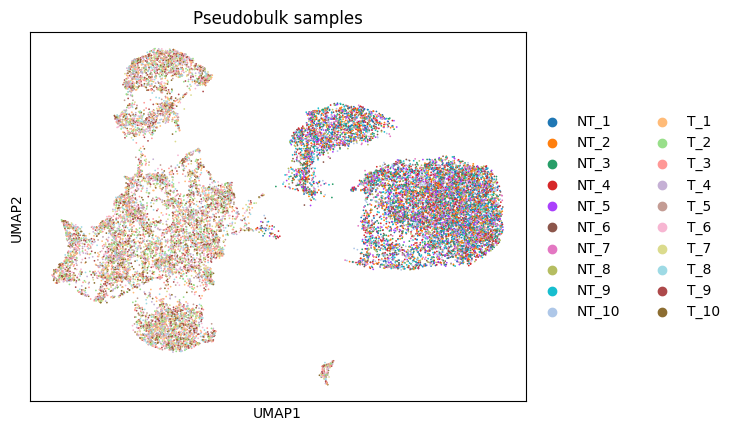

In [12]:
sc.pl.umap(rawdata,color="Pseudobulk_samples",title="Pseudobulk samples")

In [13]:
# Load the original count matrix as an anndata object to extract the non processed counts
original_data = sc.read_text('./Data/count-matrix.txt').T
rawdata.layers["counts"] = original_data[rawdata.obs.index,rawdata.var_names.tolist()].X

In [14]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    rawdata,
    sample_col='Pseudobulk_samples',
    groups_col=None,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 20 × 17147
    obs: 'doublet', '_scvi_batch', '_scvi_labels', 'per_cluster_celltype', 'Pseudobulk_samples', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells', 'n_counts'
    layers: 'psbulk_props'

In [15]:
pdata.obs["Condition"] = pdata.obs.index.str.replace("_\d*","",regex=True)
pdata.obs = pdata.obs.drop(pdata.obs.columns[pdata.obs.columns!="Condition"],axis=1)

In [16]:
df_counts = pdata.to_df()
df_counts

,7SK,7SK.2,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-8072
NT_1,6.0,18.0,32.0,1.0,8.0,300.0,13.0,0.0,45.0,44.0,...,60.0,37.0,38.0,93.0,168.0,365.0,83.0,126.0,78.0,24.0
NT_10,5.0,9.0,32.0,1.0,11.0,302.0,14.0,0.0,66.0,63.0,...,55.0,52.0,36.0,81.0,167.0,403.0,115.0,169.0,80.0,25.0
NT_2,9.0,8.0,27.0,2.0,6.0,301.0,21.0,0.0,63.0,54.0,...,69.0,32.0,41.0,102.0,171.0,351.0,84.0,150.0,70.0,20.0
NT_3,13.0,16.0,29.0,0.0,7.0,307.0,16.0,0.0,55.0,55.0,...,64.0,27.0,52.0,65.0,165.0,346.0,90.0,133.0,63.0,20.0
NT_4,6.0,13.0,16.0,4.0,12.0,290.0,14.0,0.0,54.0,58.0,...,51.0,36.0,48.0,100.0,178.0,345.0,96.0,151.0,69.0,28.0
NT_5,8.0,10.0,26.0,1.0,6.0,306.0,19.0,0.0,43.0,44.0,...,62.0,46.0,55.0,90.0,171.0,363.0,98.0,148.0,75.0,31.0
NT_6,10.0,15.0,30.0,1.0,7.0,275.0,10.0,0.0,61.0,56.0,...,45.0,30.0,43.0,78.0,150.0,333.0,71.0,129.0,63.0,30.0
NT_7,10.0,10.0,21.0,1.0,17.0,252.0,14.0,0.0,42.0,58.0,...,53.0,38.0,41.0,82.0,147.0,323.0,97.0,127.0,66.0,26.0
NT_8,9.0,11.0,26.0,2.0,14.0,251.0,11.0,0.0,42.0,51.0,...,60.0,49.0,56.0,83.0,152.0,304.0,68.0,136.0,65.0,29.0
NT_9,9.0,13.0,31.0,0.0,7.0,300.0,9.0,0.0,59.0,41.0,...,48.0,38.0,33.0,72.0,148.0,319.0,94.0,127.0,59.0,22.0


In [17]:
# Filter out the very low expressed genes
genes_to_keep = df_counts.columns[df_counts.sum(axis=0) >= 10]
df_counts = df_counts[genes_to_keep]
print(df_counts.shape)

# Show that there arent NaN values
print(df_counts.isna().sum().sum())

(20, 17147)
0


In [18]:
dds = DeseqDataSet(
    counts=df_counts,
    metadata=pdata.obs,
    design_factors="Condition",
    refit_cooks=True,
    n_cpus=30)
dds.deseq2()
dds

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.51 seconds.

Fitting dispersion trend curve...
... done in 4.46 seconds.

Fitting MAP dispersions...
... done in 1.68 seconds.

Fitting LFCs...
... done in 1.97 seconds.

Refitting 8 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



AnnData object with n_obs × n_vars = 20 × 17147
    obs: 'Condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

In [19]:
stat_res = DeseqStats(dds, n_cpus=30)

stat_res.contrast = ['Condition', 'T','NT']
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition T vs NT


... done in 2.11 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7SK,6.739392,-2.143567,0.334211,-6.413806,1.419310e-10,2.612938e-10
7SK.2,14.249346,-0.318669,0.203640,-1.564867,1.176141e-01,1.334609e-01
A1BG,61.753881,1.365651,0.108824,12.549221,4.014402e-36,1.361720e-35
A1BG-AS1,4.283575,2.057367,0.455848,4.513271,6.383532e-06,9.570554e-06
A1CF,33.803341,2.186186,0.173381,12.609136,1.880423e-36,6.414085e-36
...,...,...,...,...,...,...
ZYX,543.821997,0.550017,0.036156,15.212248,2.932968e-52,1.250413e-51
ZZEF1,107.241630,-0.195684,0.071769,-2.726593,6.399199e-03,8.059278e-03
ZZZ3,173.483141,-0.080758,0.057469,-1.405251,1.599466e-01,1.790679e-01
hsa-mir-1199,109.088842,0.565269,0.074564,7.580982,3.429486e-14,7.142645e-14


/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


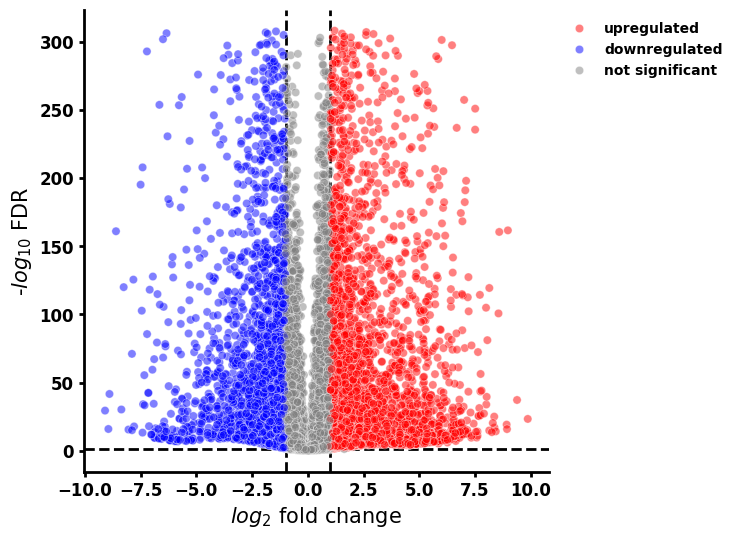

In [20]:
result = stat_res.results_df

result = result.reset_index().rename({"index":"gene_name"},axis=1)

Volcanoplot.volcano_plot(result,texto=[],path_save="./Results/Diff_exp/Volcano_plot_DESeq2.png")

In [21]:
degs_bulck = set(result[(abs(result.log2FoldChange)>1)&(result.padj<0.05)].gene_name.tolist())

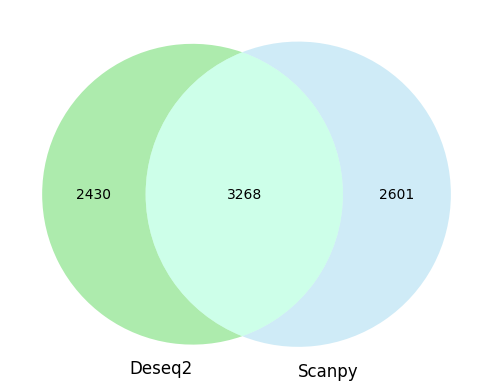

In [22]:
from matplotlib_venn import venn2

venn2((degs_bulck,degs_scanpy),("Deseq2","Scanpy"),("limegreen","skyblue"))

In [23]:
common_degs = list(degs_scanpy.intersection(degs_bulck))

In [24]:
# Up degs
common_up_degs = result[(result.log2FoldChange>1)&(result.gene_name.isin(common_degs))].gene_name.tolist()
len(common_up_degs)

2354

In [26]:
# Down degs
common_down_degs = result[(result.log2FoldChange<-1)&(result.gene_name.isin(common_degs))].gene_name.tolist()
len(common_down_degs)

914

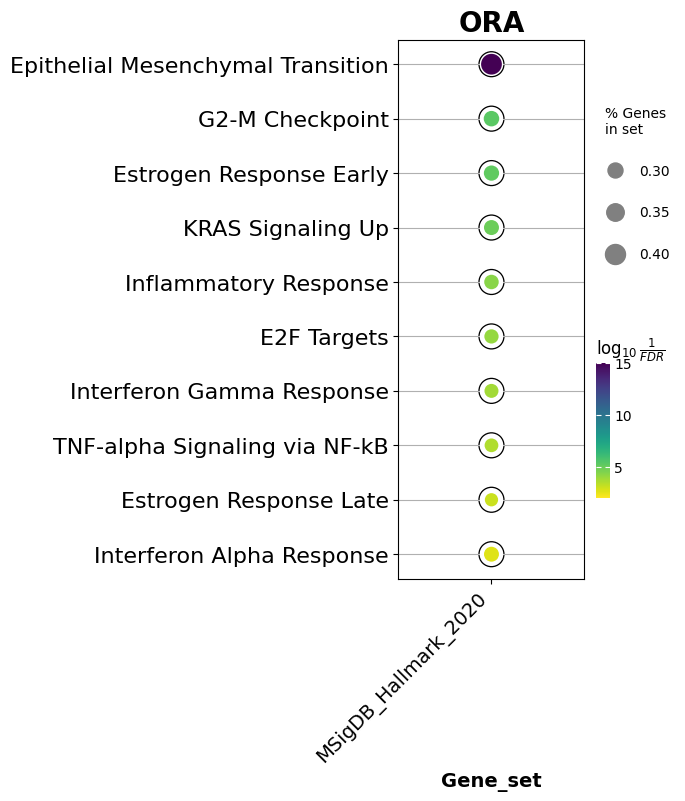

In [27]:
# Enrichr by gseapy
import gseapy as gp
#gp.get_library_name()

datasets = [ 'MSigDB_Hallmark_2020']
enr = gp.enrichr(gene_list=common_degs,
                 gene_sets=datasets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# simple plotting function
from gseapy import  dotplot

# categorical scatterplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=6,
              top_term=10,
              figsize=(3,7),
              title = "ORA",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )
plt.savefig("./Results/Diff_exp/ORA_Malign_Ductal_cells.png",bbox_inches="tight")

# Endothelial cells 

In [3]:
from utils import Functional_analysis

In [38]:
ecdata = adata[adata.obs.per_cluster_celltype=="Endothelial cell",:]
sc.tl.umap(ecdata)
sc.tl.rank_genes_groups(ecdata,groupby='Condition',use_raw=False)
df = pd.DataFrame({"gene_name":ecdata.uns["rank_genes_groups"]["names"]["T"],"lfc":ecdata.uns["rank_genes_groups"]["logfoldchanges"]["T"],"padj":ecdata.uns["rank_genes_groups"]["pvals_adj"]["T"]})

c:\Users\valle\anaconda3\envs\scrna_seq\Lib\site-packages\scanpy\tools\_umap.py:165: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}


c:\Users\valle\anaconda3\envs\scrna_seq\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\valle\anaconda3\envs\scrna_seq\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [39]:
down_degs = df[(df.padj<0.05) & (df.lfc<-1)].gene_name.tolist()
up_degs = df[(df.padj<0.05) & (df.lfc>1)].gene_name.tolist()

In [40]:
Functional_analysis.run_ora(up_degs,["GO_Biological_Process_2023"],size=20,save_path="./Results/Diff_exp/EC_UP_DEGS_Tumor_ORA.png")
Functional_analysis.run_ora(down_degs,["GO_Biological_Process_2023"],size=10,save_path="./Results/Diff_exp/EC_DOWN_DEGS_Tumor_ORA.png")

c:\Users\valle\anaconda3\envs\scrna_seq\Lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
c:\Users\valle\anaconda3\envs\scrna_seq\Lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


c:\Users\valle\anaconda3\envs\scrna_seq\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\valle\anaconda3\envs\scrna_seq\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


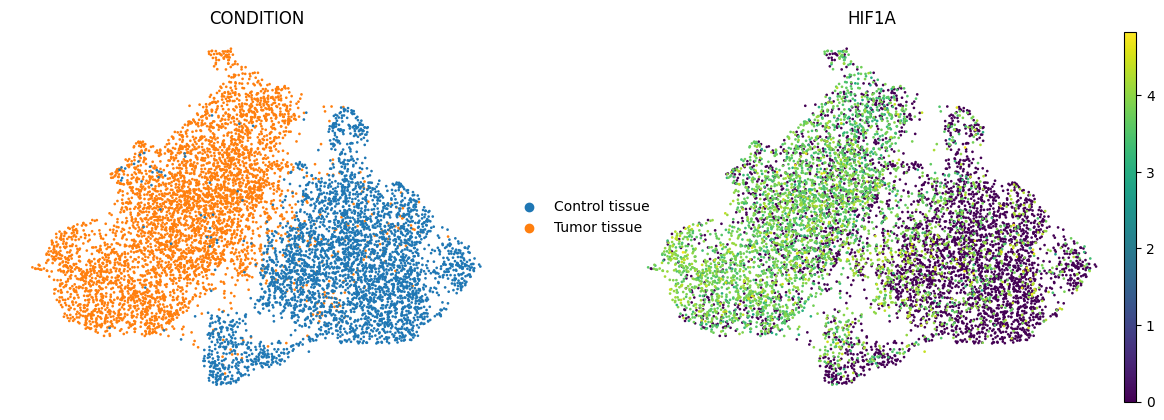

In [37]:
ecdata.obs["CONDITION"] = ecdata.obs.Condition.replace("T","Tumor tissue")
ecdata.obs["CONDITION"] = ecdata.obs.CONDITION.replace("N","Control tissue")
sc.pl.umap(ecdata,color=["CONDITION","HIF1A"],frameon=False)